# Install dependencies

In [ ]:
!pip install -q transformers
!pip install -q SentencePiece

In [ ]:
import os
import json
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

from torchvision import transforms
from torchinfo import summary as model_summary

In [ ]:
from transformers import AutoModel, AutoTokenizer
from transformers import AutoImageProcessor


Set seed for reproducibility

In [ ]:
seed_value = 42

np.random.seed(seed_value)
torch.manual_seed(seed_value)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load data

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, data_dir, transform=None):
        self.dataframe = dataframe
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_file = self.dataframe.iloc[idx]['image']
        image_path = os.path.join(self.data_dir, image_file)
        image = Image.open(image_path).convert('RGB')

        caption = self.dataframe.iloc[idx]['caption']
        label = self.dataframe.iloc[idx]['label_numeric']

        if self.transform:
            image = self.transform(image)

        return {
            'image': image,
            'caption': caption,
            'label': label,
        }

In [ ]:
train_dir = '/kaggle/input/dsc-train/Training/training-images/train-images'
train_annotation = '/kaggle/input/dsc-train/Training/vimmsd-train.json'

mapping = {
    'not-sarcasm': 0,
    'multi-sarcasm': 1,
    'image-sarcasm': 2,
    'text-sarcasm': 3
}

with open(train_annotation, 'r') as f:
    annotations = json.load(f)

df = pd.DataFrame.from_dict(annotations, orient='index')
df['label_numeric'] = df['label'].map(mapping)
df.head()

image  \
0  8ae451edcd8ebf697f8763ece249115813149c55733bf8...   
1  35370ffd6c791d6f8c4ab3dd4363ed468fab41e4824ee9...   
2  316fdd1477725b9fb1a55015ac06b68b92b50bd4303e08...   
3  8a0f34e0e30e4e5cfb306933c1d25fa801a5da78646b59...   
4  e517a5e95d1065886a7c815e82fe254381d4f9f4b244d4...   

                                             caption          label  \
0            Cô ấy trên mạng vs cô ấy ngoài đời =)))  multi-sarcasm   
1    Người tâm linh giao tiếp với người thực tế :)))    not-sarcasm   
2  Hình như Trăng hôm nay đẹp quá mọi người ạ! 😃 ...  multi-sarcasm   
3  MỌI NGƯỜI NGHĨ SAO VỀ PHÁT BIỂU CỦA SHARK VIỆT...    not-sarcasm   
4        2 tay hai nàng chứ việc gì phải lệ hai hàng  multi-sarcasm   

   label_numeric  
0              1  
1              0  
2              1  
3              0  
4              1

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
len(train_df), len(val_df)

(8644, 2161)

Compute label frequency from the training data for later use

In [ ]:
# frequency
f = train_df['label'].value_counts(normalize=True).values
# bias should be set to log(frequency)
b = np.log(train_df['label'].value_counts(normalize=True).values)

print(b)

[-0.57747445 -0.93958162 -3.18408773 -5.03926903]


In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.PILToTensor(),
])

val_dataset = CustomDataset(dataframe=val_df, data_dir=train_dir, transform=transform)
len(val_dataset)

2161

In [ ]:
batch_size = 64

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


 0


Bức ảnh này của Kim Soo-hyun và Kim Ji-won được cho biết không phải chụp trong một cảnh quay. Cả hai thực sự rất thoải mái vui vẻ khi ở cạnh nhau, kể cả khi không có camera và thân phận Hyunwoo - Haein.

Label: 0

 1


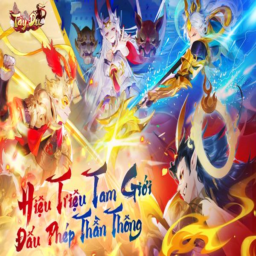

HƠN 400 NĂM KỂ TỪ KHI ĐƯỢC SÁNG TÁC VÀ ĐÃ GẦN 40 NĂM KỂ TỪ KHI TÂY DU KÝ XUẤT HIỆN TRÊN MÀN ẢNH NHỎ TV!
Cứ nhắc về Tây Du Kí thì tuổi thơ của chúng ta sẽ lại ùa về với biết bao kỉ niệm đẹp đến nao lòng.
Đó là cái thời TV vẫn còn được gọi là Vô Tuyến. Đó là thời bố chỉnh ăng ten, con ngồi dò sóng. Đó là thời 1 nghìn bằng cả bữa ăn và đó là thời cứ mỗi mùa hè về thì tất cả lũ trẻ con chúng tôi đều ước mình được làm Tôn Ngộ Không, được làm Tề Thiên Đại Thánh, được làm Mỹ Hầu Vương. Đứa nào đứa ấy cũng ước mình có 72 phép thần thông biến hóa, muốn mình có Cân Đẩu Vân để lộn 10 vạn 8 nghìn dặm và lâu lâu lại cười khành khạch gãi tai hệt như Lục Tiểu Linh Đồng ở trên màn ảnh nhỏ.
Đã gần 40 năm kể từ khi được chuyển thể thành phim, hơn 400 năm kể từ khi được Ngô Thừa Ân đặt bút sáng tác, Tây Du Ký từ lâu đã vượt xa giới hạn của 1 tác phẩm văn học đơn thuần và nay, cuộc hành trình 81 kiếp nạn của 4 thầy trò cũng đã có mặt dế yêu của bạn!
Với cốt truyện và lối chơi thẻ bài quen thuộc nhưng lại 

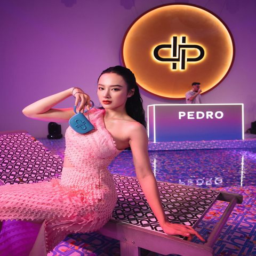

DÀN IDOL KHOE DÁNG KEO LỲ TẠI TIỆC HÈ SẮC MÀU “A SUMMER SOIREE WITH PEDRO” 
9/6/2023 vừa qua, nhiều gương mặt nổi tiếng trong showbiz đã có dịp quy tụ trong sự kiện độc đáo giới thiệu BST mới nhất PEDRO Icon Summer 2023.. 
Ca sĩ Min cùng Thiều Bảo Trâm cùng chọn style Black on Black từ outfits đến túi xách và giày của BST PEDRO Icon, những items mới nhất trong hè này. Trong khi Thiều Bảo Trâm khoe khéo đôi chân thon trên giày cao gót mũi nhọn nữ tính, thì Min trông keo lỳ hơn mọi khi với giày cao gót đế to bản, kết hợp túi vầng trăng khuyết màu silver huyền bí. Không chỉ tham gia sự kiện, Thiều Bảo Trâm còn tặng khán giả phần biểu diễn sôi động và mãn nhẵn. 
Đặc biệt, nữ hoàng sự kiện Angela Phương Trinh tái xuất thảm đỏ với phong cách siêu nữ tính và thanh lịch với giày gót nhọn của Pedro, kết hợp túi mini wallet màu xanh cyan thuộc BST biểu tượng của nhãn. Không kém chị em, ca sĩ - rapper Lona Kiều Loan xuất hiện lộng lẫy và làm chủ sân khấu với 3 bài hit mới nhất, để lại bao thương 

Đầu cầu Sài Gòn chuyến này ăn lễ chấn động, Red Bull được gọi tên vì quá “chiều chuộng” anh em
Bắt gặp hình ảnh đông đúc của người dân đi chơi lễ tại Bến Bạch Đằng hôm qua, hỏi ra mới biết mọi người đổ xô về đây để hóng 2 rappers Andree, Obito cùng cặp đôi Huyme - Hàn Hằng quẩy nhạc “đùng đùng”, vừa ăn kem uống nước vừa ngắm dàn drone đổ bộ chiếm trọn spotlight trời đêm. Khó quên nhất có lẽ là tiếng hô đồng thanh “HÚC TỚI ĐI” để khởi động màn trình diễn, chắc chuyến này nghỉ lễ xong ai cũng mạnh mẽ “húc sếp” tanh tách ha mấy ní 😉
#RedBull #RedBullHúcTớiĐi

Label: 0

 4


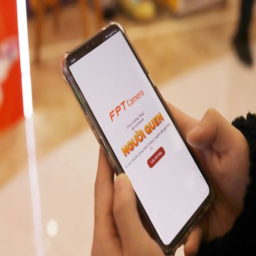

MỌI PHÉP MÀU ĐỀU CÓ THỂ XẢY ĐẾN TRONG ĐÊM GIÁNG SINH !!!
Đêm nay là đêm Giáng Sinh. Người ta thường bảo rằng trong ngày Chúa ra đời, phép màu nào cũng có thể xảy ra và với tôi thì...tôi đã được chứng kiến 2 phép màu liên tiếp. 
Với chương trình "Noel từ lạ thành quen", FPT Camera đã cho tôi thấy sự nhiệm màu của công nghệ AI Việt Nam khi mang tới trải nghiệm Giáng Sinh 4.0 ra giữa trung tâm thương mại rồi bằng cách nào đó, tất cả mọi người đang từ lạ hơ lạ hoặc, bỗng nhiên thân quen để rồi tặng nhau muôn vào tấm thiệp cùng hàng vạn lời chúc ý nghĩa. Công nghệ không làm chúng ta xa cách, mà giúp kết nối chúng ta gần nhau hơn. 
Phép màu tiếp đến chính là nụ cười ấm áp trên môi của những  người tham gia chương trình. Ai nấy cũng thật sự vui, thật sự hạnh phúc và cảm thấy được yêu thương.
Nếu tối nay bạn vẫn chưa biết đi đâu hoặc vẫn đang một mình thì hãy đi trải nghiệm công nghệ AI với tính năng nhận diện người lạ người quen trong nháy mắt siêu đỉnh nhá
#FPTCamera #TuLaThanhQuen #Noelketn

Rihanna gia nhập mảng KOC livestream chốt đơn trên một ứng dụng của Trung Quốc, sẵn sàng cho những phiên live nghìn tỷ.

Label: 0

 6


CIIN VÀ GIA ĐÌNH AN NHIÊN BỐI BỐI “QUẬY TƯNG BỪNG” BẤT PHÂN THẮNG BẠI VỚI BIỆT ĐỘI OMACHI TẠI THẢO CẦM VIÊN???
Ngày 06/05, TikToker CiiN và gia đình An Nhiên Bối Bối chia sẻ khoảnh khắc nhảy cực vui tại Thảo Cầm Viên. Đáng chú ý, khách tham quan còn ghi lại hình ảnh những mascot kì lạ xuất hiện trong màn dance battle nhí nhố lầy lội và đáng yêu này gồm Cà Chua, Trứng, Khoai Tây, Thịt Bò và Phô Mai.
Theo tin mật báo thì đây là 5 thành viên lầy lội của Biệt đội Omachi đang tổ chức vô số hoạt động thú vị khiến các em nhỏ hào hứng. Bên cạnh sàn nhảy thách đấu, Biệt đội nhí nhố còn "đốt cháy" Thảo Cầm Viên bởi màn diễu hành ấn tượng cùng điệu nhảy flashmob “độc quyền” sôi động trên nền nhạc Omachi Spaghetti bắt tai.
Đúng kiểu "Quậy bất thình lình - Ăn ngon linh đình", Omachi chu đáo chiêu đãi các gia đình món mì trộn spaghetti ngon miệng để nạp năng lượng sau khoảng thời gian "cháy" hết mình. Ba mẹ còn có giây phút ý nghĩa khi cùng con tham gia cuộc thi Vua đầu bếp nhí Omachi, tự tay nấu và

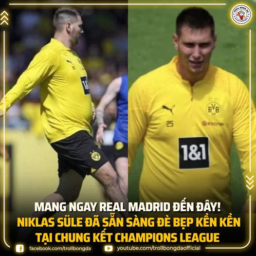

Đối thủ nặng kí :)))

Label: 0

 8


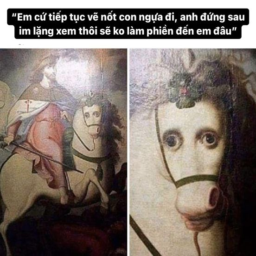

Đứng quanh em là phiền rồi anh 🥹

Label: 1

 9


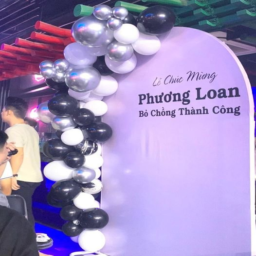

Chị Loan có ở đây không nhỉ 😅

Label: 0

 10


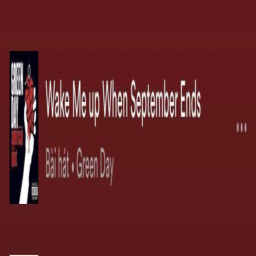

Vâng dậy đi ạ hết r

Label: 0

 11


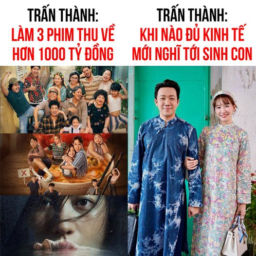

Không biết bao nhiêu mới là đủ

Label: 0

 12


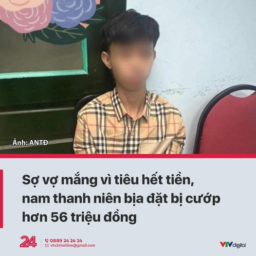

Công an quận Tây Hồ, Hà Nội cho biết đã làm rõ vụ việc một người dân trình báo bị 6 đối tượng đi trên 3 xe máy gây ra vụ cướp táo tợn trên đê An Dương Vương, xác định đây là thông tin bịa đặt.
Trước đó, vào 3h10 ngày 14/5, Công an phường Phú Thượng nhận được tin báo của anh Đ.B.T (sinh năm 2001; ở xã Phượng Dực, huyện Phú Xuyên, Hà Nội; hiện ở quận Bắc Từ Liêm, Hà Nội) về việc bị 6 người đi trên 3 xe máy cướp tài sản tại khu vực đường đê trước số 142 An Dương Vương.
Tài sản bị cướp gồm 1 chiếc túi bên trong có 1 chiếc điện thoại di động iPhone và 50 triệu đồng tiền mặt. Tổng trị giá tài sản là 56 triệu đồng.
Ngay sau khi tiếp nhận vụ việc, Công an phường Phú Thượng và Công an quận Tây Hồ đã vào cuộc. Quá trình xác minh, lực lượng xác định trình báo của anh T là sai sự thật. Số tiền trên anh T đã dùng tiêu xài cá nhân. Do lo sợ gia đình và vợ trách mắng nên đã báo bị cướp giật tài sản.
Hiện Công an quận Tây Hồ đang tiếp tục củng cố hồ sơ để xử lý theo quy định của pháp luật.

Label: 0



Có lòng nhưng không có sức 🙏

Label: 1

 14


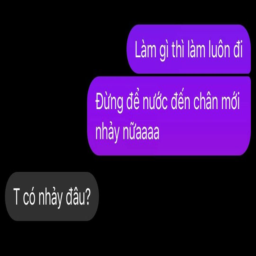

Ờ thì 👀

Label: 1

 15


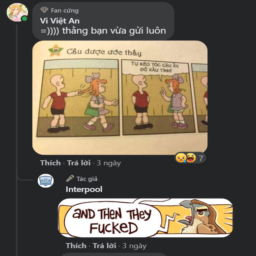

Như cái tên, đây là album tổng hợp những khoảnh khắc And then they fμcked bị nguyền rủa.
#Interpool

Label: 1

 16


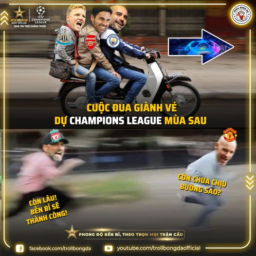

Man United và Liverpool cạnh tranh cho chiếc vé cuối cùng.
Ai sẽ là người bền bỉ hơn?
#NướctănglựcRockstar #Bền

Label: 0

 17


Kể ra kết bạn cũng không khó lắm…

Label: 0

 18


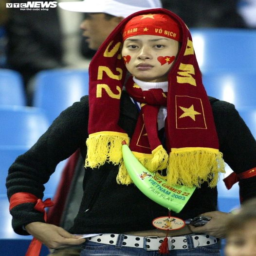

Phải dùng đến sức mạnh siêu nhiên thôi!

Label: 0

 19


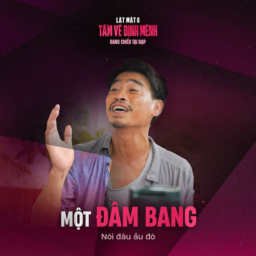

Các kiểu người trong 1 hội anh em =))
Lật Mặt 6 hiện đang công chiếu và có mặt tại các rạp trên toàn quốc.

Label: 0

 20


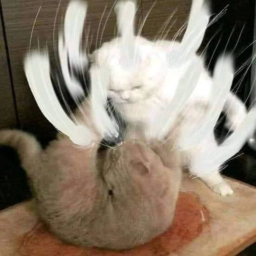

#VOZ_F33 - Công ty của ông Nguyễn Tử Quảng trúng nhiều gói thầu có những tiêu chí đặc biệt
https://voz.vn/.../cong-ty-cua-ong-nguyen-tu-quang-trung.../

Label: 0

 21


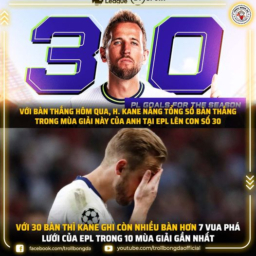

Thôi âu cũng là cái số 😕

Label: 1

 22


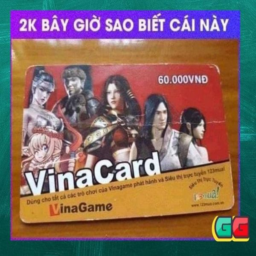

Sao mà biết được

Label: 1

 23


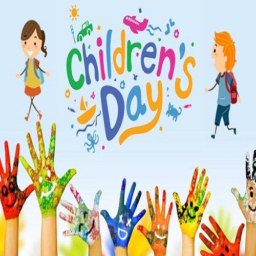

Chào tháng 6 với ngày Quốc tế Thiếu nhi.
Khi ta càng ngày càng già đi, những ký ức về tuổi thơ luôn in dấu mãi. Hãy trân trọng những khoảnh khắc trong hiện tại.
Chúc tất cả các thanh niên nhí ngày Quốc tế Thiếu nhi hạnh phúc!

Label: 0

 24


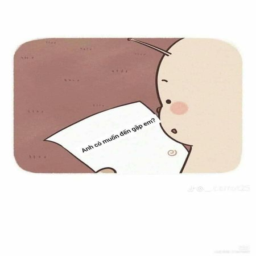

Đến ốc sên còn có đôi có cặp 🐌👍🏼 
-Kiến Ngủ-
Lạc mất nguồn gòi, ai biết nguồn cmt để bổ sung cre ạ.

Label: 0

 25


Ok

Label: 1

 26


#VOZ_F33 - Cha đẻ ChatGPT bí mật kết hôn với bạn trai
https://voz.vn/.../cha-de-chatgpt-bi-mat-ket-hon-voi-ban.../

Label: 2

 27


Đẳng cấp nhà vô địch World Cup :3

Label: 0

 28


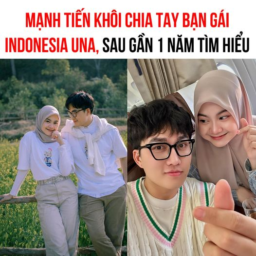

Hiện tại Una đã xoá hết ảnh và clip quay chung cùng Mạnh Tiến Khôi trên trang cá nhân của mình

Label: 0

 29


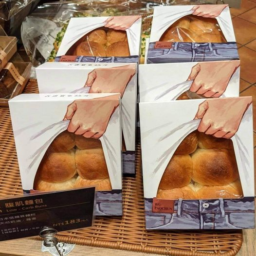

Aiiii bánh mì nóng giòn đây

Label: 0

 30


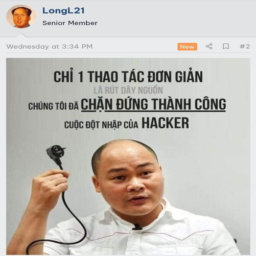

#VOZ_F33 - Hàng trăm trang web cơ quan nhà nước bị tấn công kiểu mới
Link ở comment

Label: 1

 31


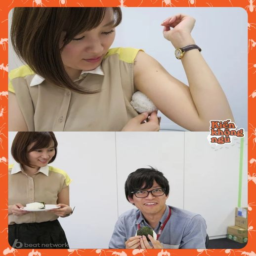

CƠM NẮM NẶN BẰNG NÁCH ĐƯỢC BÁN VỚI GIÁ x10 LẦN CƠM NẮM BÌNH THƯỜNG... 
Những cô gái trẻ dùng nách để nặn cơm nắm. Nhưng trước đó, tất cả nguyên liệu và nách sẽ được khử trùng, làm sạch để đảm bảo vệ sinh an toàn thực phẩm 🥲
Sau đó, các cô gái sẽ vận động để tiết ra mồ hôi và dùng nách thay vì lòng bàn tay để nhào và tạo hình những viên cơm... và khách hàng sẽ phải xì ra số tiền gấp 10 lần cơm nắm thông thường để được ăn chúng 😳 
- Kiến Lang Thang -

Label: 1

 32


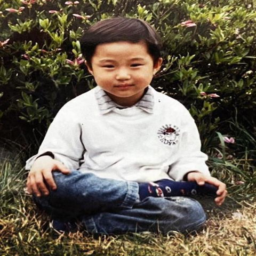

Ảnh thơ ấu kháu khỉnh của Byun Woo Seok (Lovely Runner) 🥰

Label: 0

 33


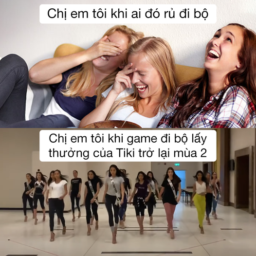

Đi bộ cày 300k, ngang 1 ngày chấm công đầy đủ rồi

Label: 0

 34


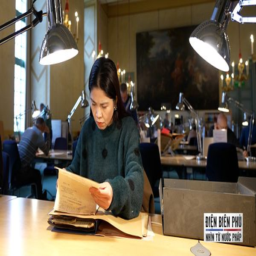

VTV ĐẶC BIỆT: ĐIỆN BIÊN PHỦ - NHÌN TỪ NƯỚC PHÁP
Khai thác kho tư liệu đồ sộ về Chiến dịch Điện Biên Phủ  
Chỉ có 4 tháng để nghiên cứu và thực hiện ghi hình tại Việt Nam và Pháp, VTV đặc biệt Điện Biên Phủ - Nhìn từ nước Pháp là hành trình gấp rút của nhóm sản xuất Ban Truyền hình đối ngoại, Đài truyền hình Việt Nam. Ê-kíp đã khai thác khối tư liệu đồ sộ về chiến dịch Điện Biên Phủ tại Trung tâm Lưu trữ của Bộ Quốc phòng Pháp, Quốc hội Pháp để tiếp cận nhiều tài liệu mới được giải mật, nhiều thông tin chưa hoặc ít được nhắc tới về sự kiện lịch sử này. Có thể kể tới những văn bản tối mật từ phía Pháp ghi lại những thừa nhận và lý giải vì sao Pháp thất bại tại Điện Biên Phủ, hay câu chuyện tiếp diễn sau khi chiến dịch kết thúc với chiến thắng thuộc về Việt Nam…
(Mời quý vị click vào ảnh để đọc chi tiết)
------
"Điện Biên Phủ - Nhìn từ nước Pháp" là phim tài liệu VTV Đặc biệt được thực hiện bởi ê-kíp của Ban Truyền hình Đối ngoại, Đài Truyền hình Việt Nam, hướng đến sự kiệ

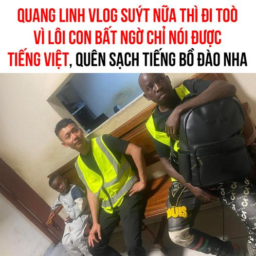

Theo chia sẻ của 1 bạn trong team, Quang Linh suýt bị “tóm” tại sân bay Angola vì khi cảnh sát sân bay giữ ông cháu Lôi Con lại hỏi thì ông cháu bất ngờ quên sạch tiếng Bồ Đào Nha và chỉ nói chuyện bằng tiếng Việt.
Điều này khiến cảnh sát nghi ngờ nên đã không cho team xuất cảnh. Các chú phải giải thích vã mồ hôi mới có thể qua được vòng kiểm soát an ninh 🥹

Label: 0

 36


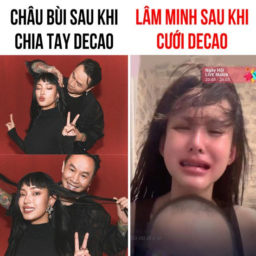

Là phụ nữ chọn đúng người chồng quan trọng lắm

Label: 0

 37


Nghi vấn Liz Kim Cương và Trịnh Thăng Bình mâu thuẫn: Unfollow nhau trên mxh, MV sắp ra mắt bị huỷ ngay trước ngày phát hành?
Chiều 13/5, B Production (công ty của Trịnh Thăng Bình) bất ngờ thông báo huỷ bỏ việc ra mắt MV "Chúng Ta Không Thể Quay Lại" của Trịnh Thăng Bình và Liz Kim Cương.
Netizen cũng phát hiện 2 người đã unfollow nhau trên Instagram, lộ rõ nghi vấn "cạch mặt". Trước đó, cả 2 đã có nhiều status và story ẩn ý về sự mâu thuẫn nhưng chưa chính thức xác nhận vấn đề trên.

Label: 0

 38


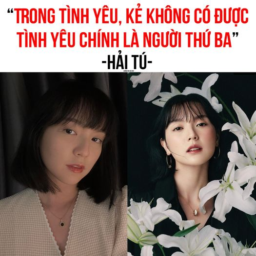

Châm ngôn của những người thích xen vào mối quan hệ của người khác

Label: 1

 39


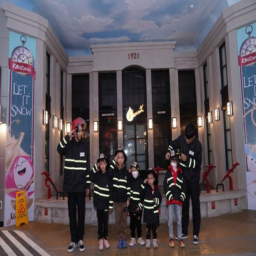

Chuyên mục không làm người đọc thất vọng
Theo danh sách của ông già noel, quà giáng sinh dành tặng cho các trẻ ngoan, vậy thì các bạn nhỏ của bệnh viện nhi trung ương chắc chắn là những em bé đứng đầu danh sách rồi. Vì thế mà mùa lễ hội này KidZania đã dành tặng cho các bạn nhỏ một buổi trải nghiệm tập làm người lớn thật vui vẻ, và sự ngọt ngào từ những chiếc bánh cupcake sắc màu, những món quà và tấm thiệp từ bạn bè.

Label: 0

 40


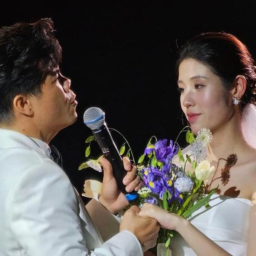

Hôn lễ của Đinh Mạnh Ninh và bà xã Thảo Trang sau hơn 10 năm yêu nhau. Lễ cưới có sự tham dự của MC Phí Linh, Dương Hoàng Yến, Vũ Hạnh Nguyên... 
Không gian tiệc trang trí như vườn cổ tích, cô dâu chú rể không kiềm được nước mắt khi trao nhau lời nguyện thề.

Label: 0

 41


BẠCH TUỘC PAUL CHỌN TÂY BAN NHA LÀ NHÀ VÔ ĐỊCH WORLD CUP !!!!
Nổi danh từ Euro 2008, chú bạch tuộc Paul đã trở nên vô cùng nổi tiếng khi đưa ra những lời tiên tri vô cùng chính xác, điển hình là chọn Tây Ban Nha dành chiến thắng trước Đức và mới đây, chú bạch tuộc này đã tiếp tục về phe Xứ Đấu Bò thay vì Hà Lan cho chức vô địch World Cup diễn ra tại Nam Phi.
Xin chúc mừng đội tuyển Tây Ban Nha, được Paul chọn thì coi như đặt 1 tay vào cup cmnr !!!!!!! Nên nhớ, ở bộ môn tiếng Anh, TBN là SPAIN và trong đó S là Superrrrr !!!!!!!!

Label: 1

 42


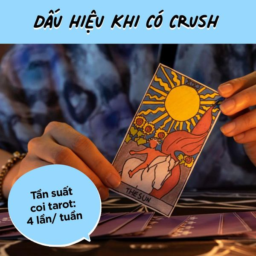

Đếm xem bạn có bao nhiêu dấu hiệu trong đây nhá 😀
Đã làm đủ các cách, kể cả tặng kem Cornetto mà vẫn ế thì là do bạn xui thui bạn ơi :)))
#Cornetto #Back2School #Thínhngon #Tạonétvàolòngcrush

Label: 3

 43


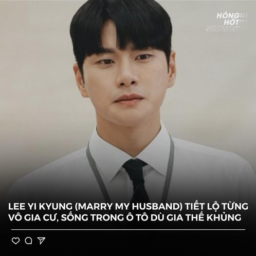

Tại fanmeeting của Choi Daniel, Lee Yi Kyung tiết lộ mình xem nam tài tử này như anh trai: “Khi anh trai tôi gọi điện mời đến đây, tôi phải làm những gì có thể. Anh ấy là một trong số ít những người quý giá trong cuộc đời tôi. 
Khi tôi vô gia cư và sống trong ô tô, anh Choi Daniel đã rời khỏi ngôi nhà anh ấy sống và đưa nó cho tôi. Anh ấy cho tôi tiền thuê nhà hàng tháng”. 
Lee Yi Kyung không nhận tiền mặt vì không muốn mối quan hệ của mình gắn liền với tiền bạc, "Anh trai của Choi Daniel sống ở tầng trên và anh ấy đã trả phí bảo trì và hóa đơn tiện ích."
Điều này khiến nhiều người bất ngờ khi Lee Yi Kyung là con trai cựu CEO của LG Innotek. Choi Daniel hỏi: “Gia đình anh không phải vẫn ổn chứ?”, Lee Yi-kyung nói đùa: “Cha tôi đang sống tốt, nhưng tôi chẳng có gì cả (vì tôi không nhận sự giúp đỡ).”

Label: 0

 44


" Tao đâu có ra trường đâu mà tụi bây cũng không tha " - Anh bảo vệ bồi hồi kể lại

Label: 1

 45


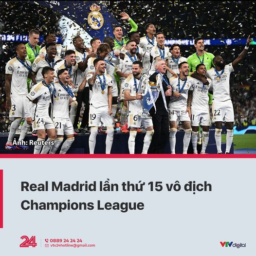

Rạng sáng 2/6, Real Madrid đã trở thành nhà vô địch Champions League mùa giải 2023-2024 sau chiến thắng 2-0 trước Dortmund ở trận chung kết tại sân Wembley (London, Anh).
Kịch bản của trận chung kết Champions League 2023-2024 đã diễn ra theo một cách quá nghiệt ngã cho Dortmund. Họ chơi hay hơn trong hơn 70 phút khi tạo ra nhiều cơ hội ghi bàn nhưng cuối cùng lại nhận thất bại. Bên cạnh khâu dứt điểm không tốt, Dortmund còn bị khuất phục bởi sự xuất sắc của Courtois.
Không ghi được bàn thắng, Dortmund đã phải nhận hai bàn thua ở 20 phút cuối của trận đấu.
Với chức vô địch mùa giải này, Real Madrid đã nối dài kỷ lục với lần thứ 15 đăng quang tại đấu trường C1/Champions League.

Label: 0

 46


LISA (BLACKPINK) xuất hiện tại Giải đua Công thức 1 Miami 2024. Cô vẫy lá cờ 🏁 là cột mốc lớn đối với sức ảnh hưởng của LISA tại thị trường quốc tế.

Label: 0

 47


Gen 2 coded.

Label: 0

 48


- Elsa
#interpool #WMO #WorldMemeOrganization

Label: 2

 49


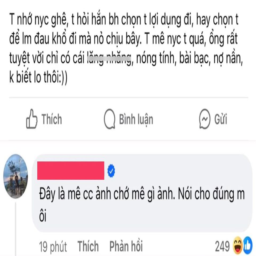

Trai xấu thì không tốt còn trai tốt thì không vui

Label: 1

 50


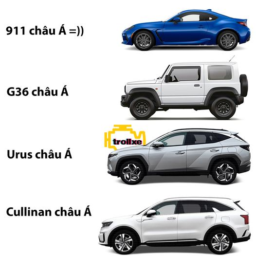

“Gọi vậy cho nó soang mồm!” – Sw*ft
#châuÁ

Label: 0

 51


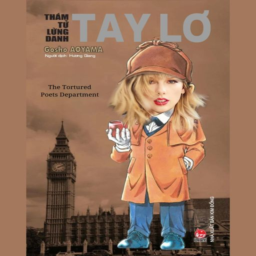

tóm tắt The Tortured Poets Department:

Label: 1

 52


👩🏻: Chiều đi bân xiển k, ăn mặc xuề xoà thôi nhé
👱‍♀️: Ô cê
Chiều:
Cre: Shoppertainer - Ngôi Sao Chốt Đơn

Label: 0

 53


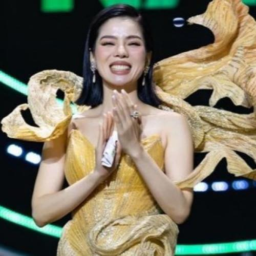

Chúc mừng Lệ Quyên đoạt giải Chị Đẹp Phòng Trà 😍😍😍

Label: 1

 54


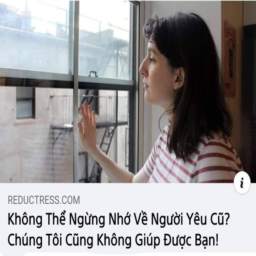

Nói như nói 😊

Label: 1

 55


😄

Label: 0

 56


"MẠNG XÃ HỘI ZING ME CHÍNH THỨC RA MẮT GIỚI TRẺ VIỆT NAM !!!"
Chắc hẳn nhiều người vẫn nhớ ngày này của 12 năm trước, ngày mà chúng ta lần đầu tiên có 1 mạng xã hội dành riêng cho giới trẻ Việt Nam.
Combo ra nét ngày đấy sẽ là bật máy lên nghe Mùa Đông Không Lạnh với Giả Vờ Yêu trên Zing mp3, vào Zing Me chơi nông trại vui vẻ, khu vườn trên mây, lướt qua tường của đứa mình thích để tưới cây và xong hết 1 lượt rồi thì mới bắt đầu chơi game gì thì chơi.
Ngoài nhưng trò kể trên thì Zing Me sau này còn có thêm cả Ủn Ỉn, Hàng Rong, Đảo Rồng và tất nhiên rồi, đặc biệt nhất chắc chắn là Gunny với hàng loạt huyền thoại như Conan SSC, ♥PéMy ♀ Xinh☼Víp ♥, ChủLòGạch99 hay HEROTAYDO.
Hôm nay 3.8, chúc mừng sinh nhật Zing Me. Chúc mừng ngày tròn 1 giáp mà các bạn đã tạo nên tuổi thơ không thể quên với tất cả bọn mình.
Tràn ram hôm nay chút tại Zing là 1 trời kỉ niệm quá tuyệt vời.....

Label: 0

 57


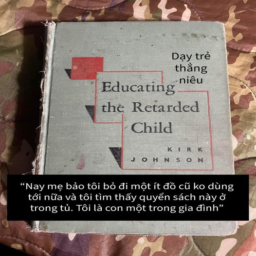

Thật sự mất lòng =)))))

Label: 1

 58


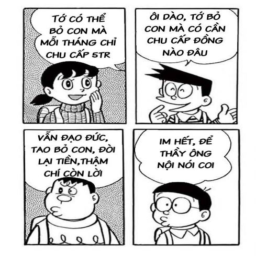

Bảng xếp hạng đạo đức

Label: 1

 59


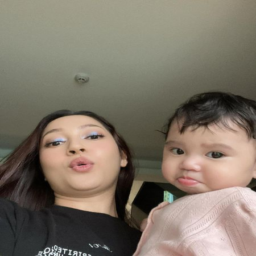

Lần đầu Bảo Anh khoe ảnh chụp cùng con gái Misumi ❤️

Label: 0

 60


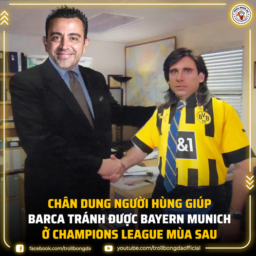

Mãi là anh em

Label: 0

 61


Mai Ngô said: Đấu đá chi cho mệt vậy mấy mẹ

Label: 1

 62


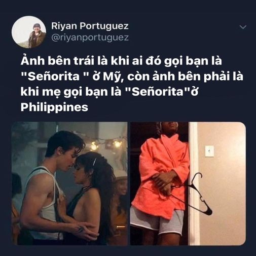

Một từ, hai số phận 🥰

Label: 1

 63


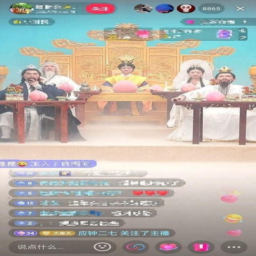

Lai chim tiệc buffe bàn đào

Label: 1


In [ ]:
val_label_counts = {
    0: 0, 1: 0, 2: 0, 3:0,
}

for batch in val_loader:
    images = batch['image']
    captions = batch['caption']
    labels = batch['label']

    for i in range(len(images)):
        print('\n', i)
        display(transforms.ToPILImage()(images[i]))
        print(captions[i])

        val_label_counts[labels[i].item()] += 1
        print('\nLabel:', labels[i].item())

    break

We can see that the data is extremely imbalanced

In [ ]:
for key, value in val_label_counts.items():
    print(key, '\n', value)

0 
 40
1 
 21
2 
 2
3 
 1


# Build model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


The model contains two encoders: a text encoder and an image encoder.

Each encoder extracts feature from a modality.

In [ ]:
class BaseTextEncoder(nn.Module):

    def __init__(self, model_name, tokenizer_class, model_class, max_len, trust_remote_code=False):
        super(BaseTextEncoder, self).__init__()

        self.max_len = max_len
        self.tokenizer = tokenizer_class.from_pretrained(model_name)
        self.text_transformer = model_class.from_pretrained(model_name, trust_remote_code=trust_remote_code)

    def forward(self, texts):
        texts = texts.tolist() if isinstance(texts, np.ndarray) else texts
        inputs = self.tokenizer(texts, padding='max_length', truncation=True, max_length=self.max_len, return_tensors='pt').to(device)
        outputs = self.text_transformer(**inputs)
        return outputs.last_hidden_state    # (B, N, D)


class ViSoBERT(BaseTextEncoder):
    def __init__(self, max_len=257):
        super(ViSoBERT, self).__init__(model_name='uitnlp/visobert', tokenizer_class=AutoTokenizer, model_class=AutoModel, max_len=max_len)

In [ ]:
class BaseImageEncoder(nn.Module):

    def __init__(self, model_name, tokenizer_class, model_class):
        super(BaseImageEncoder, self).__init__()
        self.processor = tokenizer_class.from_pretrained(model_name)
        self.vision_transformer = model_class.from_pretrained(model_name)

    def forward(self, images):
        images = images.to(device)
        inputs = self.processor(images=images, return_tensors="pt").to(device)
        outputs = self.vision_transformer(**inputs)
        return outputs.last_hidden_state    # (B, N, D)


class DINOv2_Base(BaseImageEncoder):
    def __init__(self):
        super(DINOv2_Base, self).__init__(model_name='facebook/dinov2-base', tokenizer_class=AutoImageProcessor, model_class=AutoModel)

Implement the attention mechanism to combine textual and visual feature.

To save memory, we used the **additive** attention instead of the more common **multiplicative** attention.

In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, d_model, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()

        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)

        self.f_h = nn.Linear(self.d_model, self.d_model)
        self.w_h = nn.Parameter(torch.randn(self.d_model))
        self.f_o = nn.Linear(self.d_model, self.d_model)


    def forward(self, phi):

        h = self.f_h(phi)    # (B, N, D)
        scores = torch.matmul(h, self.w_h) / np.sqrt(self.d_model)  # (B, N)

        alphas = torch.softmax(scores, dim=-1)  # (B, N)
        alphas = alphas.unsqueeze(-1)           # (B, N, 1)

        if self.dropout is not None:
            alphas = self.dropout(alphas)

        c = torch.sum(alphas * h, dim=1, keepdim=True)    # (B, 1, D)
        v = c * h             # (B, N, D)
        o = h + self.f_o(v)   # (B, N, D)
        return o


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

In [ ]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"

    def __init__(self, d_model, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(d_model, dropout), 2)    # 2 sub-layers: multi-head additive-attention & fully connected feed-forward
        self.d_model = d_model

    def forward(self, x):
        x = self.sublayer[0](x, self.self_attn)
        return self.sublayer[1](x, self.feed_forward)


class Encoder(nn.Module):
    "Core encoder is a stack of N layers"

    def __init__(self, layer, N, C=4, dropout_rate=0.5):
        super(Encoder, self).__init__()
        self.image_encoder = DINOv2_Base()
        self.text_encoder = ViSoBERT()

        self.layers = clones(layer, N)  # Composition blocks
        self.norm = LayerNorm(layer.d_model)

        self.classifier = nn.Sequential(
            nn.Linear(layer.d_model, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, C)
        )

    def freeze_encoders(self):
        for param in self.image_encoder.parameters():
            param.requires_grad = False
        for param in self.text_encoder.parameters():
            param.requires_grad = False

    def forward(self, images, captions):
        phi_x = self.image_encoder(images)
        phi_t = self.text_encoder(captions)

        phi_xt = torch.cat((phi_x, phi_t), axis=1)
        o_xt = phi_xt

        for layer in self.layers:
            o_xt = layer(o_xt)

        o_xt = self.norm(o_xt)
        x = self.classifier(o_xt.mean(dim=1))
        return x

There is only 1 transformer block with 1 head.

We tried different numbers of blocks and heads and found that this modest setting worked best.

In [ ]:
N = 1
d_model = 768
d_ff = 3072
dropout = 0.1

c = copy.deepcopy
attn = MultiHeadedAttention(d_model, dropout)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)

# Training

Bagging: We trained multiple models on different subsets of the training data, and aggregated their predictions.

First, we use the bootstrapping technique to create different variants of the training data.

In [ ]:
def create_bootstrap_loader(df, batch_size):

    random_state = np.random.randint(0, 10000)
    print('\nrandom_state: ', random_state)

    bootstrapped_df = df.sample(n=len(df), replace=True, random_state=random_state)
    print(bootstrapped_df['label_numeric'].value_counts())

    class_counts = bootstrapped_df['label_numeric'].value_counts().sort_index().values
    sample_weights = 1. / class_counts
    bootstrapped_df['weight'] = bootstrapped_df['label_numeric'].map(lambda label: sample_weights[label])

    sampler = WeightedRandomSampler(
        weights = bootstrapped_df['weight'].values,
        num_samples = len(bootstrapped_df['weight']),
        replacement = True
    )

    subset = CustomDataset(dataframe=bootstrapped_df, data_dir=train_dir, transform=transform)
    loader = DataLoader(subset, batch_size=batch_size, sampler=sampler)
    return loader

Each model is trained on a different variant of the training data, using its own optimizer.

In [ ]:
num_models = 12

models = []
optimizers = []
train_loaders = []

for _ in range(num_models):

    bootstrapped_loader = create_bootstrap_loader(train_df, batch_size)

    model = Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N).to(device)
    model.freeze_encoders()


    for name, p in model.named_parameters():
        if p.requires_grad:
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
                print(f"Initialized parameter: {name}")
            elif "bias" in name:
                nn.init.zeros_(p)
                print(f"Initialized parameter: {name}")

    model.classifier[-1].bias.data.copy_(torch.tensor(b))

    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                                lr=0.004, momentum=0.9, weight_decay=5e-4)


    models.append(model)
    optimizers.append(optimizer)
    train_loaders.append(bootstrapped_loader)


best_val_losses = [float('inf')] * num_models
best_val_accs = [0.0] * num_models


random_state:  7270
label_numeric
0    4819
1    3388
2     375
3      62
Name: count, dtype: int64


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/471k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/390M [00:00<?, ?B/s]

Some weights of XLMRobertaModel were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized parameter: layers.0.self_attn.f_h.weight
Initialized parameter: layers.0.self_attn.f_h.bias
Initialized parameter: layers.0.self_attn.f_o.weight
Initialized parameter: layers.0.self_attn.f_o.bias
Initialized parameter: layers.0.feed_forward.w_1.weight
Initialized parameter: layers.0.feed_forward.w_1.bias
Initialized parameter: layers.0.feed_forward.w_2.weight
Initialized parameter: layers.0.feed_forward.w_2.bias
Initialized parameter: classifier.0.weight
Initialized parameter: classifier.0.bias
Initialized parameter: classifier.3.weight
Initialized parameter: classifier.3.bias

random_state:  860
label_numeric
0    4826
1    3398
2     350
3      70
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of XLMRobertaModel were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized parameter: layers.0.self_attn.f_h.weight
Initialized parameter: layers.0.self_attn.f_h.bias
Initialized parameter: layers.0.self_attn.f_o.weight
Initialized parameter: layers.0.self_attn.f_o.bias
Initialized parameter: layers.0.feed_forward.w_1.weight
Initialized parameter: layers.0.feed_forward.w_1.bias
Initialized parameter: layers.0.feed_forward.w_2.weight
Initialized parameter: layers.0.feed_forward.w_2.bias
Initialized parameter: classifier.0.weight
Initialized parameter: classifier.0.bias
Initialized parameter: classifier.3.weight
Initialized parameter: classifier.3.bias

random_state:  5390
label_numeric
0    4877
1    3359
2     350
3      58
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of XLMRobertaModel were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized parameter: layers.0.self_attn.f_h.weight
Initialized parameter: layers.0.self_attn.f_h.bias
Initialized parameter: layers.0.self_attn.f_o.weight
Initialized parameter: layers.0.self_attn.f_o.bias
Initialized parameter: layers.0.feed_forward.w_1.weight
Initialized parameter: layers.0.feed_forward.w_1.bias
Initialized parameter: layers.0.feed_forward.w_2.weight
Initialized parameter: layers.0.feed_forward.w_2.bias
Initialized parameter: classifier.0.weight
Initialized parameter: classifier.0.bias
Initialized parameter: classifier.3.weight
Initialized parameter: classifier.3.bias

random_state:  5191
label_numeric
0    4939
1    3289
2     368
3      48
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of XLMRobertaModel were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized parameter: layers.0.self_attn.f_h.weight
Initialized parameter: layers.0.self_attn.f_h.bias
Initialized parameter: layers.0.self_attn.f_o.weight
Initialized parameter: layers.0.self_attn.f_o.bias
Initialized parameter: layers.0.feed_forward.w_1.weight
Initialized parameter: layers.0.feed_forward.w_1.bias
Initialized parameter: layers.0.feed_forward.w_2.weight
Initialized parameter: layers.0.feed_forward.w_2.bias
Initialized parameter: classifier.0.weight
Initialized parameter: classifier.0.bias
Initialized parameter: classifier.3.weight
Initialized parameter: classifier.3.bias

random_state:  5734
label_numeric
0    4854
1    3362
2     374
3      54
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of XLMRobertaModel were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized parameter: layers.0.self_attn.f_h.weight
Initialized parameter: layers.0.self_attn.f_h.bias
Initialized parameter: layers.0.self_attn.f_o.weight
Initialized parameter: layers.0.self_attn.f_o.bias
Initialized parameter: layers.0.feed_forward.w_1.weight
Initialized parameter: layers.0.feed_forward.w_1.bias
Initialized parameter: layers.0.feed_forward.w_2.weight
Initialized parameter: layers.0.feed_forward.w_2.bias
Initialized parameter: classifier.0.weight
Initialized parameter: classifier.0.bias
Initialized parameter: classifier.3.weight
Initialized parameter: classifier.3.bias

random_state:  6265
label_numeric
0    4783
1    3450
2     356
3      55
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of XLMRobertaModel were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized parameter: layers.0.self_attn.f_h.weight
Initialized parameter: layers.0.self_attn.f_h.bias
Initialized parameter: layers.0.self_attn.f_o.weight
Initialized parameter: layers.0.self_attn.f_o.bias
Initialized parameter: layers.0.feed_forward.w_1.weight
Initialized parameter: layers.0.feed_forward.w_1.bias
Initialized parameter: layers.0.feed_forward.w_2.weight
Initialized parameter: layers.0.feed_forward.w_2.bias
Initialized parameter: classifier.0.weight
Initialized parameter: classifier.0.bias
Initialized parameter: classifier.3.weight
Initialized parameter: classifier.3.bias

random_state:  466
label_numeric
0    4886
1    3321
2     372
3      65
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of XLMRobertaModel were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized parameter: layers.0.self_attn.f_h.weight
Initialized parameter: layers.0.self_attn.f_h.bias
Initialized parameter: layers.0.self_attn.f_o.weight
Initialized parameter: layers.0.self_attn.f_o.bias
Initialized parameter: layers.0.feed_forward.w_1.weight
Initialized parameter: layers.0.feed_forward.w_1.bias
Initialized parameter: layers.0.feed_forward.w_2.weight
Initialized parameter: layers.0.feed_forward.w_2.bias
Initialized parameter: classifier.0.weight
Initialized parameter: classifier.0.bias
Initialized parameter: classifier.3.weight
Initialized parameter: classifier.3.bias

random_state:  4426
label_numeric
0    4838
1    3401
2     351
3      54
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of XLMRobertaModel were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized parameter: layers.0.self_attn.f_h.weight
Initialized parameter: layers.0.self_attn.f_h.bias
Initialized parameter: layers.0.self_attn.f_o.weight
Initialized parameter: layers.0.self_attn.f_o.bias
Initialized parameter: layers.0.feed_forward.w_1.weight
Initialized parameter: layers.0.feed_forward.w_1.bias
Initialized parameter: layers.0.feed_forward.w_2.weight
Initialized parameter: layers.0.feed_forward.w_2.bias
Initialized parameter: classifier.0.weight
Initialized parameter: classifier.0.bias
Initialized parameter: classifier.3.weight
Initialized parameter: classifier.3.bias

random_state:  5578
label_numeric
0    4941
1    3326
2     332
3      45
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of XLMRobertaModel were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized parameter: layers.0.self_attn.f_h.weight
Initialized parameter: layers.0.self_attn.f_h.bias
Initialized parameter: layers.0.self_attn.f_o.weight
Initialized parameter: layers.0.self_attn.f_o.bias
Initialized parameter: layers.0.feed_forward.w_1.weight
Initialized parameter: layers.0.feed_forward.w_1.bias
Initialized parameter: layers.0.feed_forward.w_2.weight
Initialized parameter: layers.0.feed_forward.w_2.bias
Initialized parameter: classifier.0.weight
Initialized parameter: classifier.0.bias
Initialized parameter: classifier.3.weight
Initialized parameter: classifier.3.bias

random_state:  8322
label_numeric
0    4744
1    3511
2     334
3      55
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of XLMRobertaModel were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized parameter: layers.0.self_attn.f_h.weight
Initialized parameter: layers.0.self_attn.f_h.bias
Initialized parameter: layers.0.self_attn.f_o.weight
Initialized parameter: layers.0.self_attn.f_o.bias
Initialized parameter: layers.0.feed_forward.w_1.weight
Initialized parameter: layers.0.feed_forward.w_1.bias
Initialized parameter: layers.0.feed_forward.w_2.weight
Initialized parameter: layers.0.feed_forward.w_2.bias
Initialized parameter: classifier.0.weight
Initialized parameter: classifier.0.bias
Initialized parameter: classifier.3.weight
Initialized parameter: classifier.3.bias

random_state:  1685
label_numeric
0    4878
1    3366
2     337
3      63
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of XLMRobertaModel were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized parameter: layers.0.self_attn.f_h.weight
Initialized parameter: layers.0.self_attn.f_h.bias
Initialized parameter: layers.0.self_attn.f_o.weight
Initialized parameter: layers.0.self_attn.f_o.bias
Initialized parameter: layers.0.feed_forward.w_1.weight
Initialized parameter: layers.0.feed_forward.w_1.bias
Initialized parameter: layers.0.feed_forward.w_2.weight
Initialized parameter: layers.0.feed_forward.w_2.bias
Initialized parameter: classifier.0.weight
Initialized parameter: classifier.0.bias
Initialized parameter: classifier.3.weight
Initialized parameter: classifier.3.bias

random_state:  769
label_numeric
0    4879
1    3377
2     340
3      48
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of XLMRobertaModel were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized parameter: layers.0.self_attn.f_h.weight
Initialized parameter: layers.0.self_attn.f_h.bias
Initialized parameter: layers.0.self_attn.f_o.weight
Initialized parameter: layers.0.self_attn.f_o.bias
Initialized parameter: layers.0.feed_forward.w_1.weight
Initialized parameter: layers.0.feed_forward.w_1.bias
Initialized parameter: layers.0.feed_forward.w_2.weight
Initialized parameter: layers.0.feed_forward.w_2.bias
Initialized parameter: classifier.0.weight
Initialized parameter: classifier.0.bias
Initialized parameter: classifier.3.weight
Initialized parameter: classifier.3.bias


In [ ]:
model_summary(models[-1])

Layer (type:depth-idx)                                                 Param #
Encoder                                                                --
├─DINOv2_Base: 1-1                                                     --
│    └─Dinov2Model: 2-1                                                --
│    │    └─Dinov2Embeddings: 3-1                                      (1,506,048)
│    │    └─Dinov2Encoder: 3-2                                         (85,072,896)
│    │    └─LayerNorm: 3-3                                             (1,536)
├─ViSoBERT: 1-2                                                        --
│    └─XLMRobertaModel: 2-2                                            --
│    │    └─XLMRobertaEmbeddings: 3-4                                  (11,920,896)
│    │    └─XLMRobertaEncoder: 3-5                                     (85,054,464)
│    │    └─XLMRobertaPooler: 3-6                                      (590,592)
├─ModuleList: 1-3                                       

In [ ]:
models[-1].classifier[-1].bias

Parameter containing:
tensor([-0.5775, -0.9396, -3.1841, -5.0393], device='cuda:0',
       requires_grad=True)

In [ ]:
optimizers[-1].param_groups[0]['lr']

0.004

In [ ]:
num_epochs = 7
criterion = nn.CrossEntropyLoss().to(device)

for epoch in range(num_epochs):
    print(f'\n\nEpoch {epoch + 1}/{num_epochs}')

    for i, (model, optimizer, train_loader) in enumerate(zip(models, optimizers, train_loaders)):

        model.train()
        train_loss = 0.0
        train_correct, train_total = 0, 0

        for batch in train_loader:

            images = batch['image']
            captions = batch['caption']
            targets = batch['label'].to(device)

            optimizer.zero_grad()

            logits = model(images, captions)
            loss = criterion(logits, targets)
            train_loss += loss.item()

            preds = logits.argmax(dim=1)
            train_correct += (preds == targets).sum().item()
            train_total += targets.size(0)

            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total


        model.eval()
        val_loss = 0.0
        val_correct, val_total = 0, 0

        with torch.no_grad():

            for batch in val_loader:

                images = batch['image']
                captions = batch['caption']
                targets = batch['label'].to(device)

                logits = model(images, captions)
                loss = criterion(logits, targets)
                val_loss += loss.item()

                preds = logits.argmax(dim=1)
                val_correct += (preds == targets).sum().item()
                val_total += targets.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total


        if val_loss <= best_val_losses[i] and val_acc >= best_val_accs[i]:
            best_val_losses[i] = val_loss
            best_val_accs[i] = val_acc

            torch.save(model.state_dict(), f'model_{i+1}_best.pth')
            print(f'\n\tModel {i+1} \t Train Loss: {train_loss:.5f} \t Train Acc: {train_acc:.5f} \t Val Loss: {val_loss:.5f} \t Val Acc: {val_acc:.5f} \t (Updated)')

        else:
            print(f'\n\tModel {i+1} \t Train Loss: {train_loss:.5f} \t Train Acc: {train_acc:.5f} \t Val Loss: {val_loss:.5f} \t Val Acc: {val_acc:.5f}')




Epoch 1/7

	Model 1 	 Train Loss: 0.99337 	 Train Acc: 0.58225 	 Val Loss: 1.03068 	 Val Acc: 0.57011 	 (Updated)

	Model 2 	 Train Loss: 1.02708 	 Train Acc: 0.57578 	 Val Loss: 1.05802 	 Val Acc: 0.54558 	 (Updated)

	Model 3 	 Train Loss: 1.02268 	 Train Acc: 0.56444 	 Val Loss: 0.89924 	 Val Acc: 0.61870 	 (Updated)

	Model 4 	 Train Loss: 0.93960 	 Train Acc: 0.60331 	 Val Loss: 1.05241 	 Val Acc: 0.54558 	 (Updated)

	Model 5 	 Train Loss: 1.04505 	 Train Acc: 0.56490 	 Val Loss: 0.98758 	 Val Acc: 0.57520 	 (Updated)

	Model 6 	 Train Loss: 1.09327 	 Train Acc: 0.54037 	 Val Loss: 0.99790 	 Val Acc: 0.56270 	 (Updated)

	Model 7 	 Train Loss: 0.98257 	 Train Acc: 0.59058 	 Val Loss: 1.04362 	 Val Acc: 0.55900 	 (Updated)

	Model 8 	 Train Loss: 1.01771 	 Train Acc: 0.57531 	 Val Loss: 1.00256 	 Val Acc: 0.57751 	 (Updated)

	Model 9 	 Train Loss: 0.97058 	 Train Acc: 0.59174 	 Val Loss: 1.01596 	 Val Acc: 0.57288 	 (Updated)

	Model 10 	 Train Loss: 1.02026 	 Train Acc: 0.5839

Training takes:

- 13.2 GB GPU

- 7 hours 20 mins

# Evaluation

Load best models and evaluate ensemble

In [ ]:
os.chdir(r'/kaggle/working')
os.listdir()

['model_11_best.pth',
 'model_7_best.pth',
 'model_2_best.pth',
 'model_5_best.pth',
 'model_10_best.pth',
 'model_8_best.pth',
 'model_9_best.pth',
 '.virtual_documents',
 'model_6_best.pth',
 'model_3_best.pth',
 'model_4_best.pth',
 'model_1_best.pth',
 'model_12_best.pth']

In [ ]:
for idx, model in enumerate(models):
    model.load_state_dict(torch.load(f'model_{idx+1}_best.pth'))
    model.eval()

/tmp/ipykernel_30/1083084298.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'model_{idx+1}_best.pth'))


Evaluate the performance of the ensemble

In [ ]:
val_loss = 0.0
val_correct = 0
val_total = 0

all_preds = []
all_targets = []

with torch.no_grad():

    for batch in val_loader:

        images = batch['image']
        captions = batch['caption']
        targets = batch['label'].to(device)

        logits = [model(images, captions) for model in models]
        logits = torch.stack(logits)  # (num_models, batch_size, num_classes)

        ensemble_logits = logits.mean(dim=0)  # Average logits
        loss = criterion(ensemble_logits, targets)
        val_loss += loss.item()

        preds = ensemble_logits.argmax(dim=1)  # Final predictions
        val_correct += (preds == targets).sum().item()
        val_total += targets.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

val_loss /= len(val_loader)
val_acc = val_correct / val_total

print(f'Ensemble models - Validation Loss: {val_loss:.5f}, Validation Accuracy: {val_acc:.5f}')

Ensemble models - Validation Loss: 0.75256, Validation Accuracy: 0.66682


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(all_targets, all_preds)
print(f"Accuracy: {accuracy:.5f}")

print("\nClassification Report:")
print(classification_report(all_targets, all_preds))

Accuracy: 0.66682

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.64      0.71      1210
           1       0.58      0.76      0.66       846
           2       0.36      0.27      0.31        84
           3       0.17      0.05      0.07        21

    accuracy                           0.67      2161
   macro avg       0.47      0.43      0.44      2161
weighted avg       0.68      0.67      0.67      2161



In [ ]:
from sklearn.metrics import f1_score

f1_micro = f1_score(all_targets, all_preds, average='micro')
f1_macro = f1_score(all_targets, all_preds, average='macro')
f1_weighted = f1_score(all_targets, all_preds, average='weighted')

print(f'\n F1 Score (Micro): {f1_micro:.5f} \n\n F1 Score (Macro): {f1_macro:.5f} \n\n F1 Score (Weighted): {f1_weighted:.5f}')


 F1 Score (Micro): 0.66682 

 F1 Score (Macro): 0.43723 

 F1 Score (Weighted): 0.66569


Evaluate the performance of each model separately

We can see that each individual model severely overfits the training data.  Bagging helps reduce overfitting, therefore, the ensemble has better loss and accuracy.

In [ ]:
for idx, model in enumerate(models):
    model.eval()

    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_loader:

            images = batch['image']
            captions = batch['caption']
            targets = batch['label'].to(device)

            logits = model(images, captions)
            loss = criterion(logits, targets)
            val_loss += loss.item()

            preds = logits.argmax(dim=1)
            val_correct += (preds == targets).sum().item()
            val_total += targets.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    print(f'\nBest model {idx+1} - Validation Loss: {val_loss:.5f}, Validation Accuracy: {val_acc:.5f}')


Best model 1 - Validation Loss: 0.81289, Validation Accuracy: 0.65895

Best model 2 - Validation Loss: 0.90451, Validation Accuracy: 0.62749

Best model 3 - Validation Loss: 0.87386, Validation Accuracy: 0.63906

Best model 4 - Validation Loss: 0.87608, Validation Accuracy: 0.64692

Best model 5 - Validation Loss: 0.85661, Validation Accuracy: 0.65155

Best model 6 - Validation Loss: 0.87793, Validation Accuracy: 0.66312

Best model 7 - Validation Loss: 0.88221, Validation Accuracy: 0.61777

Best model 8 - Validation Loss: 0.85595, Validation Accuracy: 0.63767

Best model 9 - Validation Loss: 0.83516, Validation Accuracy: 0.63350

Best model 10 - Validation Loss: 0.84817, Validation Accuracy: 0.65062

Best model 11 - Validation Loss: 0.82846, Validation Accuracy: 0.64785

Best model 12 - Validation Loss: 0.84833, Validation Accuracy: 0.64137


# Reference

Paper:

- [Fastformer: Additive Attention Can Be All You Need](https://arxiv.org/abs/2108.09084)

- [Composing Text and Image for Image Retrieval - An Empirical Odyssey](https://openaccess.thecvf.com/content_CVPR_2019/papers/Vo_Composing_Text_and_Image_for_Image_Retrieval_-_an_Empirical_CVPR_2019_paper.pdf)

Code:

- [The Annotated Transformer](https://nlp.seas.harvard.edu/annotated-transformer/)

Hyperparameter tuning:

- [Choosing a learning rate](https://datascience.stackexchange.com/questions/410/choosing-a-learning-rate)

- [Does small batch size improve the model?](https://datascience.stackexchange.com/questions/72922/does-small-batch-size-improve-the-model)

- [How to initialize final layer to get a good starting loss?](https://stats.stackexchange.com/questions/606359/how-to-initialize-final-layer-to-get-a-good-starting-loss/606498#606498)

- [No change in accuracy using Adam Optimizer when SGD works fine](https://stats.stackexchange.com/questions/313278/no-change-in-accuracy-using-adam-optimizer-when-sgd-works-fine)